In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
path = '/home/alvaro/Escritorio/FIUBA/Programación/Organizacion de datos'
df= pd.read_csv(path + '/train.csv')
dfasd=df
#Fuente: https://es.investing.com/currencies/usd-mxn-historical-data
#AGREGAR EL PATH CORRESPONDIENTE
path1 = '/home/alvaro/Descargas'
dolar= pd.read_csv(path1 + '/Datos históricos USD_MXN.csv')
dolar.columns = ["fecha", "last", "opening", "max", "min", "std"]
dolar.drop(["std", "opening", "opening", "max", "min"], axis=1 ,inplace=True)
#Paso a formato fecha correctamente y luego creo columnas mes y año
dolar['date'] = pd.to_datetime(dolar['fecha'], format="%b %Y")
dolar.drop(["fecha"], axis=1, inplace=True)
dolar.columns= ['price', "date"]
#El csv ponia los numeros con punto en vez de coma.
dolar['price'] = dolar['price'].replace(',', '.', regex=True).astype(float)
dolar["year"] = dolar.date.dt.year
dolar['month'] = dolar.date.dt.month
dolar.drop(["date"], axis=1, inplace=True)
df['fecha'] = pd.to_datetime(df['fecha'])
df['year'] = df['fecha'].dt.year
df['month']= df['fecha'].dt.month
#Agrego la columna precio en dolar por propiedad, en el dataframe original
newDf= pd.merge(df, dolar, on=['year', 'month'], how='left')
newDf["dollar_price"] = newDf.apply(lambda row: row["precio"]/row["price"], axis=1)
#Filtro dejando las cosas útiles.
#Para agregar una columna, se debe agregar aca y luego agregarla al merge
df = newDf.filter(["id", "tipodepropiedad", "habitaciones",'garages', 'banos', 'ciudad',
                   'provincia','metroscubiertos', 'metrostotales', 'idzona', 'fecha',
                   'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
                   'centroscomercialescercanos', 'dollar_price' ])
def asignarMetros(metroscubiertos, metrostotales):
    if (metroscubiertos != 0 and metrostotales == 0):
        return metroscubiertos
    else:
        return metrostotales
    
#Arreglando, no pueden haber propiedades con metros cubiertos pero sin metros totales
df['metrostotales'].fillna(0, inplace=True)
df['metrostotales'] = df.apply(lambda x: asignarMetros(x['metroscubiertos'],x['metrostotales']),axis=1)
df.head()
#Filtrando el garage, lotes, hospedaje, otros
filtroTerreno = df["tipodepropiedad"].isin(["Huerta", "Nave industrial", "Terreno", "Terreno comercial", 
                                            "Bodega comercial", "Terreno industrial"])
dfTerreno = df[filtroTerreno]
dfTerreno.tipodepropiedad.value_counts()
#Dropeo todos los terrenos que tienen habitaciones ya que si las tienen no serian terrenos.
dfTerreno = dfTerreno[dfTerreno["habitaciones"].isna()]
dfTerreno.tipodepropiedad.value_counts()
#Limpiando las propiedades tipo casa, no pueden no tener al menos una habitacion o baño y no pueden
#tener metros no cubiertos
filtro1 = df["tipodepropiedad"].isin(["Apartamento", "Casa", "Casa en condominio", "Edificio"
                                        "Casa uso de suelo", "Rancho", "Quinta Vacacional"])
dfCasas = df[filtro1]
dfCasas = dfCasas[np.isfinite(dfCasas['habitaciones'])]
dfCasas = dfCasas[np.isfinite(dfCasas['banos'])]
dfCasas = dfCasas[np.isfinite(dfCasas['metroscubiertos'])]
dfCasas.garages.fillna(0, inplace=True)
df = pd.merge(dfCasas, dfTerreno, on=['id', 'tipodepropiedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos'
                                      ,'ciudad','provincia','metrostotales','idzona','fecha', 'gimnasio','usosmultiples',
                                       'piscina','escuelascercanas','centroscomercialescercanos', 'dollar_price'], how='outer')

In [131]:
dfasd.tipodepropiedad.value_counts()

Casa                             141717
Apartamento                       57341
Casa en condominio                19297
Terreno                            9945
Local Comercial                    3055
Oficina comercial                  1741
Bodega comercial                   1406
Edificio                           1396
Terreno comercial                  1326
Casa uso de suelo                   708
Quinta Vacacional                   395
Duplex                              343
Villa                               340
Inmuebles productivos urbanos       200
Rancho                              170
Local en centro comercial           165
Departamento Compartido             141
Otros                               134
Nave industrial                      76
Terreno industrial                   31
Huerta                               20
Lote                                  5
Garage                                1
Hospedaje                             1
Name: tipodepropiedad, dtype: int64

In [151]:
def cambiarNombre(word):
    if(word == 1.0):
        return "Con gimnasio"
    else:
        return "Sin gimnasio"

In [148]:
filtroGimnasios = dfasd["gimnasio"].isin([1.0])
dfGim = dfasd[filtroGimnasios]
#g = sns.catplot(x='tipodepropiedad', y='dollar_price', kind="bar",  data=dfGim, height=4,aspect=2)
group = dfGim.groupby("tipodepropiedad").agg({"tipodepropiedad":{"amount" : "count"}})
group.reset_index(inplace=True)
group.columns = ["tipodepropiedad", "amount"]
group = group[group["tipodepropiedad"].isin(["Apartamento", "Casa", "Casa en condominio"])]
group

,tipodepropiedad,amount
0,Apartamento,7591
1,Casa,6105
2,Casa en condominio,1262


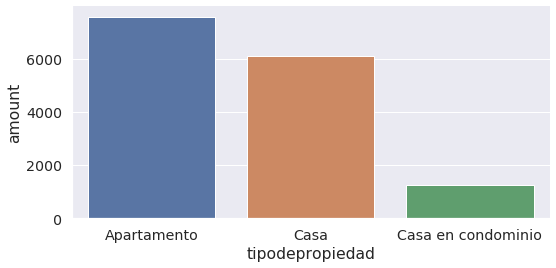

In [149]:
g = sns.catplot(x='tipodepropiedad', y='amount',
                kind="bar",  data=group, height=4,aspect=2)

/home/alvaro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


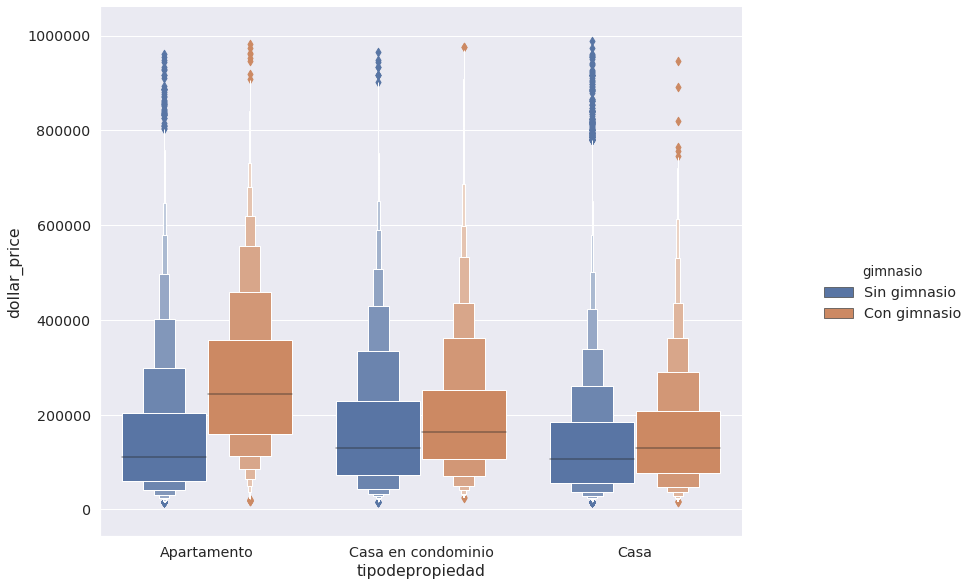

In [152]:
dfPools = df[df.tipodepropiedad.isin(["Apartamento", "Casa", "Casa en condominio"])]
dfPools["gimnasio"] = dfPools.apply(lambda x: cambiarNombre(x['gimnasio']),axis=1)
sns.set(font_scale=1.3)
g = sns.catplot(x='tipodepropiedad', y='dollar_price', hue = "gimnasio",
                kind="boxen",  data=dfPools, height=4,aspect=2)
g.fig.set_size_inches(15,10)

/home/alvaro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [107]:
dfPools.piscinaWord.value_counts(normalize=True)

Sin piscina    0.908281
Con piscina    0.091719
Name: piscinaWord, dtype: float64